In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var
import sys
from functools import partial
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
from candlesticks import candlesticks
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
multi_periods = [5, 10, 20, 40, 80, 160]
#multi_periods = [2, 5, 7, 10, 12, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 160, 320] 
#multi_periods = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 60, 80, 100, 120, 140, 160] 
roc_periods = [5, 10]
vol_lookback = 200
smooth = int(np.ceil(periods/4))
atr_periods = 80

In [3]:
contract = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
contract = contract.loc['20190101': '20191231']

In [4]:
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

31026.176951223097

In [5]:
vol_candles = group_by_volume(contract, avg_vol)

In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [7]:
def ema(data, periods):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    up = (data.ema_fast > data.ema_slow) * 1
    down = (data.ema_fast < data.ema_slow) * 1
    return up - down

In [8]:
def breakout(data, periods):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).rename(periods, inplace=True)

In [9]:
def diff(data, periods):
    up = (data.close.diff(periods) > 0) * 1
    down = (data.close.diff(periods) < 0) * 1
    return (up - down).rename(periods, inplace=True)

In [10]:
def acc(data, periods):
    up = (data.close.pct_change(periods).pct_change(periods) > 0) * 1
    down = (data.close.pct_change(periods).pct_change(periods) < 0) * 1
    return (up - down).rename(periods, inplace=True)

In [11]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [12]:
vols = vol(data, vol_lookback)

In [13]:
def combine(data, multi_periods, funcs):
    result = pd.DataFrame()
    for func in funcs:
        result[func.__name__] = pd.DataFrame([func(data, p) for p in multi_periods]).T.sum(axis=1)
    return result

In [14]:
forecasts = pd.DataFrame([breakout(data, p) for p in multi_periods]).T

In [15]:
multiplier = 10/forecasts.mean(axis=1).abs().mean()
multiplier

34.672654218860785

In [16]:
forecasts.abs().mean()

5      0.585685
10     0.403136
20     0.283981
40     0.206953
80     0.144240
160    0.106476
dtype: float64

In [17]:
multi = 10/forecasts.abs().mean()
multi

5      17.074022
10     24.805546
20     35.213634
40     48.320158
80     69.328922
160    93.918054
dtype: float64

In [18]:
scaled_forecasts = (forecasts *multi).clip(lower=-20, upper=20)
scaled_forecasts

,5,10,20,40,80,160
label,,,,,,
0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0
4,-17.074022,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
7330,17.074022,20.0,20.0,20.0,20.0,20.0
7331,17.074022,20.0,20.0,20.0,20.0,20.0
7332,0.000000,0.0,0.0,0.0,0.0,0.0


In [19]:
scaled_forecasts.abs().mean()

5      10.000000
10      8.062713
20      5.679618
40      4.139059
80      2.884799
160     2.129516
dtype: float64

In [20]:
scaled_forecasts.corr()

,5,10,20,40,80,160
5,1.000000,0.829231,0.695433,0.593128,0.494419,0.424109
10,0.829231,1.000000,0.838491,0.715014,0.595694,0.510835
20,0.695433,0.838491,1.000000,0.852846,0.710803,0.609670
40,0.593128,0.715014,0.852846,1.000000,0.833803,0.715329
80,0.494419,0.595694,0.710803,0.833803,1.000000,0.857825
160,0.424109,0.510835,0.609670,0.715329,0.857825,1.000000


In [21]:
combined_forecast = scaled_forecasts.mean(axis=1).ewm(span=5).mean().rename('combined')
combined_forecast

label
0        0.000000
1        0.000000
2        0.000000
3        0.000000
4       -1.092414
          ...    
7330    11.882505
7331    14.425783
7332     9.617188
7333     6.411459
7334     3.325749
Name: combined, Length: 7335, dtype: float64

In [22]:
combined_forecast.abs().mean(), combined_forecast.abs().std()

(4.466466907547785, 4.180088012552625)

In [23]:
#forecasts = (combine(data, multi_periods, [breakout])*multiplier).clip(lower=-20, upper=20)
#forecasts['diff'] = pd.DataFrame([diff(data, p) for p in roc_periods]).T.mean(axis=1)
#forecasts['combined'] = forecasts.sum(axis=1).ewm(span=50).mean()

In [24]:
data = data.join(combined_forecast*2.5)
data = data.iloc[200:]

In [25]:
#plot(data[['close',  'ema','combined']])

In [26]:
output = data.set_index('date')[['open','combined']]

In [27]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, .3, .5,1,2,3, 4,5,10, 11, 15]:
    b = v_backtester(output.open, output.combined, i)
    r = perf_var(b, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [28]:
stats

,0.0,0.3,0.5,1.0,2.0,3.0,4.0,5.0,10.0,11.0,15.0
Annual return,0.392099,0.340532,0.326417,0.287108,0.263392,0.186168,0.114266,0.0812346,0.00938897,0.0248104,0.0783261
Cumulative returns,0.258262,0.225708,0.216731,0.191575,0.176285,0.125876,0.078031,0.0557364,0.0065108,0.0171648,0.0537634
Annual volatility,0.121472,0.119587,0.121213,0.119539,0.114041,0.116787,0.114712,0.10702,0.0831796,0.077916,0.0637457
Sharpe ratio,2.78547,2.51149,2.39193,2.17186,2.10773,1.52032,1.00041,0.78309,0.153664,0.35328,1.21483
Calmar ratio,11.2816,9.74783,8.42477,9.6617,7.14971,4.84168,2.58743,1.79155,0.222446,0.528284,1.89687
Stability,0.939891,0.928068,0.874317,0.87134,0.892991,0.845265,0.843439,0.767612,0.527964,0.702486,0.753424
Max drawdown,-0.0347558,-0.0349341,-0.0387449,-0.0297161,-0.0368395,-0.0384511,-0.0441621,-0.0453432,-0.0422078,-0.0469642,-0.0412923
Omega ratio,1.59137,1.5129,1.48751,1.43494,1.42377,1.29829,1.18682,1.14593,1.0259,1.0626,1.24224
Sortino ratio,4.59115,4.07399,3.95522,3.4998,3.4246,2.45728,1.5109,1.17895,0.231178,0.525442,1.91265
Skew,-0.0185029,-0.0528128,0.105959,-0.0246815,0.0113991,0.255671,-0.00148068,0.0711752,0.270642,0.0626642,0.15312


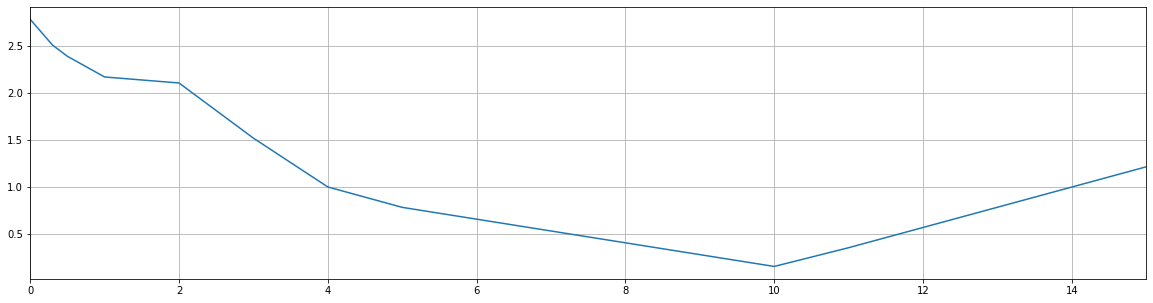

In [29]:
stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

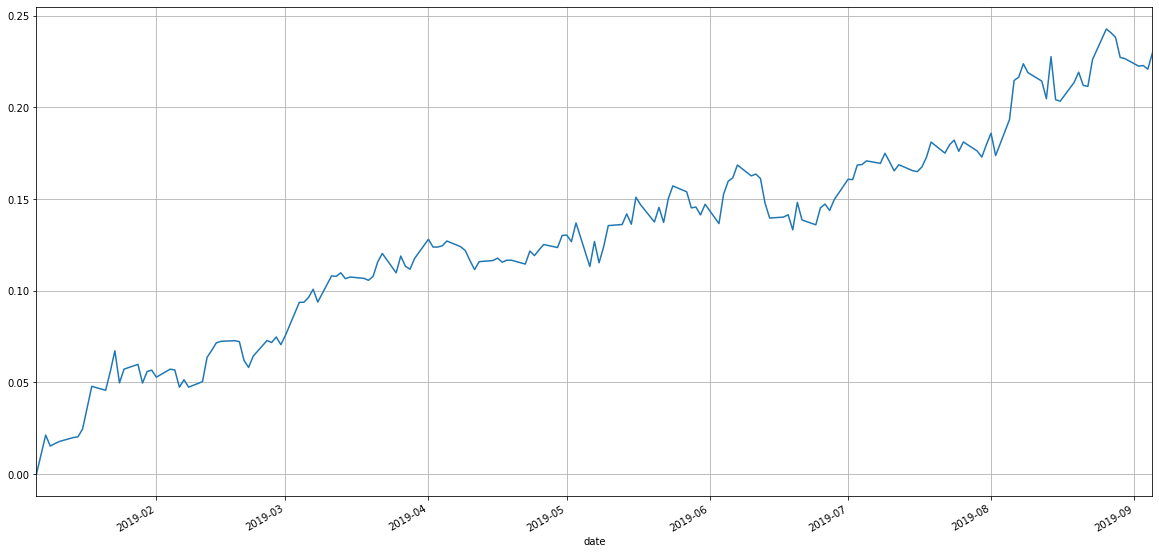

In [30]:
np.log(returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

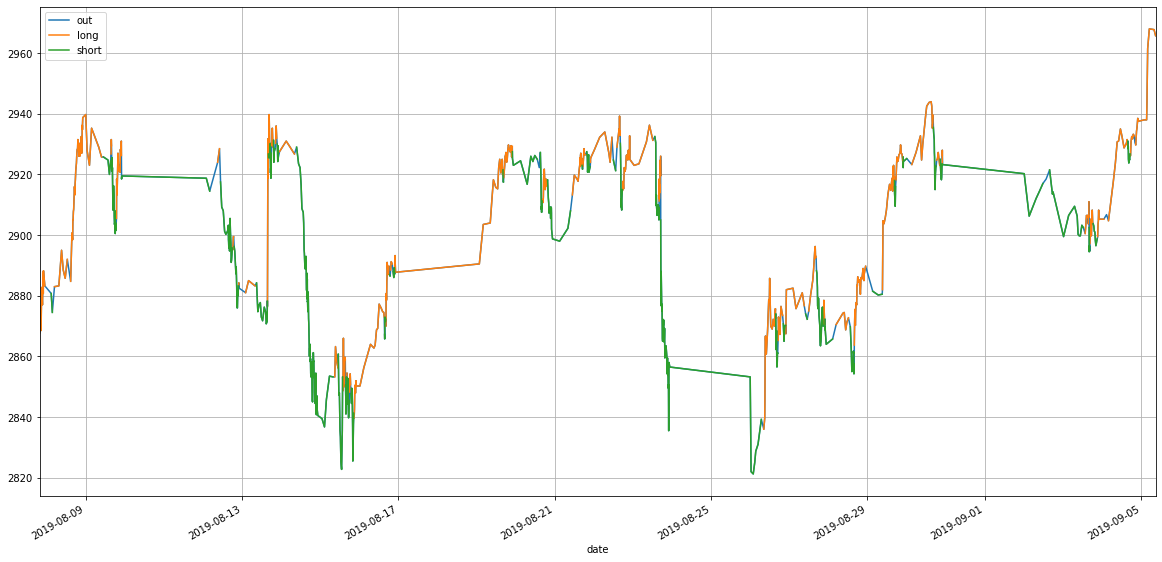

In [31]:
chart_price(output.open.iloc[-1000:], output.combined.iloc[-1000:], 0);